## EOF analysis of IPSL-CM6A-LR

In [21]:
import os
from glob import glob
from cdo import Cdo

cdo = Cdo()
cdo.debug = True  # print debug output

# =======================================================
# PATHS
# =======================================================
model_name = "IPSL-CM6A-LR"
base_in = f"/data/projects/nckf/cmip6/historical/{model_name}"
base_out = f"/data/projects/nckf/frekle/CMIP6_data/{model_name}"
regrid_ref = f"{base_out}/thetao/thetao_3D_regrid_{model_name}_r1i1p1f1.nc"
gridfile = f"{base_out}/grid_1x1.txt"

# =======================================================
# STEP 1: Create a valid 1°×1° grid file (for remapping)
# =======================================================
if not os.path.exists(gridfile):
    print("Creating clean 1°×1° grid description file...")

    # Get grid description from existing 1x1 regridded file
    grid_text = cdo.griddes(input=f"-selname,thetao {regrid_ref}")

    # Handle list return type (convert to string)
    if isinstance(grid_text, list):
        grid_text = "".join(grid_text)

    # Clean out comments and blank lines
    lines = [
        l for l in grid_text.splitlines()
        if l.strip() and not l.strip().startswith("#")
    ]

    # Write cleaned grid description
    with open(gridfile, "w") as f:
        f.write("\n".join(lines))

    print(f"✅ Clean grid file created: {gridfile}")

    # --- Validate grid file with CDO before using ---
    try:
        test_out = cdo.griddes(input=f"{gridfile}")
        print("\n✅ Grid file accepted by CDO:\n")
        print(test_out)
    except Exception as e:
        print(f"\n⚠️ Grid file validation failed: {e}")
else:
    print(f"✅ Using existing grid file: {gridfile}")

# =======================================================
# STEP 2: Regrid all IPSL members
# =======================================================
vars_to_process = ["thetao"]

for var in vars_to_process:
    print(f"\n===== Processing variable: {var} =====")

    # Input pattern (matches all members)
    search_pattern = os.path.join(base_in, "r*/Oyear", var, f"{var}_Oyear_*_185001-201412.nc")
    infiles = sorted(glob(search_pattern))

    if not infiles:
        print(f"⚠️ No files found for {var} in {search_pattern}")
        continue

    # Create output directory
    var_outdir = os.path.join(base_out, var)
    os.makedirs(var_outdir, exist_ok=True)

    for infile in infiles:
        member = infile.split("/")[-1].split("_")[6]  # e.g., r1i1p1f1
        outfile = os.path.join(var_outdir, f"{var}_regrid_{member}.nc")

        if os.path.exists(outfile):
            print(f"   ✅ Already exists: {outfile}")
            continue

        print(f"→ Regridding {infile}")

        try:
            cdo.remapnn(
                gridfile,
                input=infile,
                output=outfile,
                options="-O -s"
            )
            print(f"✅ Saved: {outfile}")
        except Exception as e:
            print(f"❌ Error while regridding {infile}: {e}")

print("\n🎯 Step 1 complete: All members regridded to 1°×1° grid.")






✅ Using existing grid file: /data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/grid_1x1.txt

===== Processing variable: thetao =====
→ Regridding /data/projects/nckf/cmip6/historical/IPSL-CM6A-LR/r10i1p1f1/Oyear/thetao/thetao_Oyear_IPSL-CM6A-LR_historical_r10i1p1f1_gn_185001-201412.nc
# DEBUG - start =============================================================
CALL  :cdo -O -s -O -s -remapnn,/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/grid_1x1.txt /data/projects/nckf/cmip6/historical/IPSL-CM6A-LR/r10i1p1f1/Oyear/thetao/thetao_Oyear_IPSL-CM6A-LR_historical_r10i1p1f1_gn_185001-201412.nc /data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao/thetao_regrid_185001-201412.nc.nc
STDOUT:
STDERR:

cdo    remapnn (Abort): Invalid grid description file /data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/grid_1x1.txt!

# DEBUG - end ===============================================================
RETURNCODE:1
Error in calling operator remapnn with:
>>> cdo -O -s -O -s -remapnn,/data/proje

In [ ]:
#!/usr/bin/env python3
# ============================================================
# Step 1 — EOF analysis for IPSL-CM6A-LR (θ and SSS)
# Freja Klejnstrup · DMI / AU · 2025
# ============================================================

import os
import random
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.standard import Eof as EofStd

# -------------------- SETTINGS --------------------
model = "IPSL-CM6A-LR"
variables = ["thetao", "so"]
indir  = f"/data/projects/nckf/frekle/CMIP6_data/{model}/"
outdir = f"/data/projects/nckf/frekle/EOF_results/{model}/{variables[0]}_and_{variables[1]}/"
figdir = f"/data/users/frekle/EOF/{model}/Figures/"
os.makedirs(outdir, exist_ok=True)
os.makedirs(figdir, exist_ok=True)

n_modes_total = 10
n_modes_plot  = 3
random.seed(42)

# -------------------- FUNCTIONS --------------------
def normalize_longitudes(ds):
    """Convert lon 0–360 → -180–180 and sort."""
    lon = ds["lon"]
    lon = ((lon + 180) % 360) - 180
    ds = ds.assign_coords(lon=lon).sortby("lon")
    return ds

def run_eof_numpy(anom_stacked, w_stacked):
    solver = EofStd(anom_stacked.values, weights=w_stacked.values)
    eofs_np = solver.eofsAsCorrelation(neofs=n_modes_total)
    pcs_np  = solver.pcs(npcs=n_modes_total, pcscaling=1)
    vf_np   = solver.varianceFraction()[:n_modes_total]

    eofs = xr.DataArray(
        eofs_np,
        dims=("mode","space"),
        coords={"mode": np.arange(1, n_modes_total+1), "space": anom_stacked.space},
        name="eofs_corr",
    )
    pcs = xr.DataArray(
        pcs_np,
        dims=("time","mode"),
        coords={"time": anom_stacked.time, "mode": np.arange(1, n_modes_total+1)},
        name="pcs",
    )
    vf  = xr.DataArray(
        vf_np,
        dims=("mode",),
        coords={"mode": np.arange(1, n_modes_total+1)},
        name="variance_fraction",
    )
    return eofs, pcs, vf


def plot_eofs(eofs_map, pcs, vf, varname, member):
    """Plot first 3 EOFs + PCs using Cartopy"""
    fig, axes = plt.subplots(
        n_modes_plot, 2, figsize=(12, 9),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    for i in range(n_modes_plot):
        ax_map = axes[i, 0]
        pcm = ax_map.pcolormesh(
            eofs_map.lon, eofs_map.lat, eofs_map.isel(mode=i),
            cmap="RdBu_r", vmin=-1, vmax=1, transform=ccrs.PlateCarree()
        )
        ax_map.coastlines()
        ax_map.add_feature(cfeature.LAND, color="lightgray")
        ax_map.set_extent([-100, 20, 0, 70])
        plt.colorbar(pcm, ax=ax_map, orientation="vertical", shrink=0.8)
        ax_map.set_title(f"EOF {i+1} ({vf[i].values*100:.1f}%)")

        # PC
        ax_pc = axes[i, 1]
        ax_pc.plot(pcs.time, pcs[:, i], color="k")
        ax_pc.set_title(f"PC {i+1}")
        ax_pc.set_xlabel("Time")

    plt.suptitle(f"{model} {member} · {varname.upper()}")
    plt.tight_layout()
    plt.savefig(f"{figdir}/{varname}_EOFs_{member}.png", dpi=300)
    plt.close(fig)


# -------------------- MAIN --------------------
def main():
    for var in variables:
        vardir = os.path.join(indir, var)
        members = sorted([m for m in os.listdir(vardir)
                          if m.startswith(f"{var}_masked_r")])

        plot_members = set(random.sample(members, min(3, len(members))))

        for file in members:
            infile = os.path.join(vardir, file)
            ds = xr.open_dataset(infile)
            ds = normalize_longitudes(ds)
            da = ds[var]

            if "olevel" in da.dims:
                da = da.isel(olevel=0)

            anom = da - da.mean(dim="time", skipna=True)
            lat, lon = anom.lat, anom.lon
            weights_2d = np.sqrt(np.cos(np.deg2rad(lat)))
            weights_2d = xr.DataArray(
                np.tile(weights_2d.values[:, np.newaxis], (1, len(lon))),
                dims=("lat","lon"), coords={"lat":lat,"lon":lon},
            )

            anom_stacked = anom.stack(space=("lat","lon")).dropna("space", how="all")
            w_stacked = weights_2d.stack(space=("lat","lon")).sel(space=anom_stacked.space)

            eofs, pcs, vf = run_eof_numpy(anom_stacked, w_stacked)

            eofs_map = (
                eofs.assign_coords(space=anom_stacked.space)
                .unstack("space")
                .transpose("mode","lat","lon")
            )

            combined = xr.Dataset({
                "eofs_corr": eofs_map,
                "pcs": pcs,
                "variance_fraction": vf,
            })
            outfile = os.path.join(
                outdir, f"EOF_{var}_{file.split('_r')[-1].split('.')[0]}.nc"
            )
            combined.to_netcdf(outfile)

            if file in plot_members:
                plot_eofs(eofs_map, pcs, vf, var, file.split('_r')[-1].split('.')[0])

    print("\n🎯 Step 1 complete — 10 EOF modes saved, 3 plotted correctly (Atlantic focus).")

# --------------------------------------------------
if __name__ == "__main__":
    main()





/tmp/ipykernel_1930732/876048943.py:127: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)
/tmp/ipykernel_1930732/876048943.py:127: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)
/tmp/ipykernel_1930732/876048943.py:127: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent st


🎯 Step 1 complete — 10 EOF modes saved, 3 plotted correctly (Atlantic focus).


/tmp/ipykernel_1930732/876048943.py:127: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)



🎨 Will plot figures for: ['thetao_masked_r4i1p1f1.nc', 'thetao_masked_r13i1p1f1.nc', 'thetao_masked_r10i1p1f1.nc']

=== Processing thetao: thetao_masked_r10i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_10i1p1f1.nc


📊 Saved figure → /data/users/frekle/EOF/IPSL-CM6A-LR/Figures//thetao_EOFs_10i1p1f1_atlantic.png
=== Processing thetao: thetao_masked_r11i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_11i1p1f1.nc
=== Processing thetao: thetao_masked_r12i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_12i1p1f1.nc
=== Processing thetao: thetao_masked_r13i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_13i1p1f1.nc


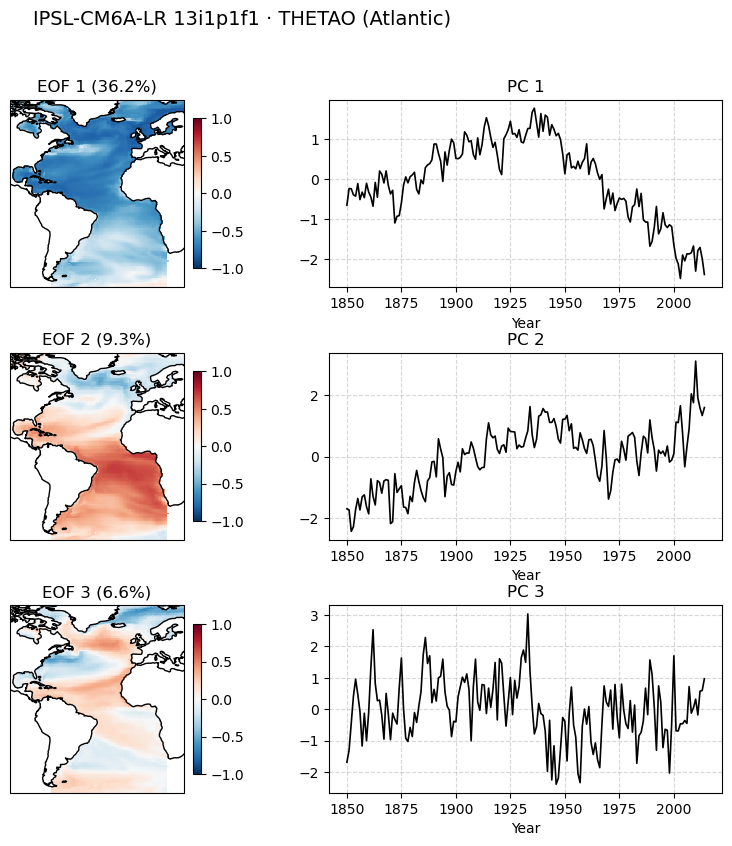

📊 Saved figure → /data/users/frekle/EOF/IPSL-CM6A-LR/Figures//thetao_EOFs_13i1p1f1_atlantic.png
=== Processing thetao: thetao_masked_r14i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_14i1p1f1.nc
=== Processing thetao: thetao_masked_r15i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_15i1p1f1.nc
=== Processing thetao: thetao_masked_r16i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_16i1p1f1.nc
=== Processing thetao: thetao_masked_r17i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_17i1p1f1.nc
=== Processing thetao: thetao_masked_r18i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_18i1p1f1.nc
=== Processing thetao: thetao_masked_r19i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_19i1p1f1.nc
=== Processing thetao: thetao_masked_r1i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_1i1p1f1.nc
=== Processing thetao: thetao_masked_r20i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_20i1p1f1.nc
=== Processing thetao: thetao_masked_r21i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_21i1p1f1.nc
=== Processing thetao: thetao_masked_r22i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_22i1p1f1.nc
=== Processing thetao: thetao_masked_r23i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_23i1p1f1.nc
=== Processing thetao: thetao_masked_r24i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_24i1p1f1.nc
=== Processing thetao: thetao_masked_r25i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_25i1p1f1.nc
=== Processing thetao: thetao_masked_r26i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_26i1p1f1.nc
=== Processing thetao: thetao_masked_r2i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_2i1p1f1.nc
=== Processing thetao: thetao_masked_r3i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_3i1p1f1.nc
=== Processing thetao: thetao_masked_r4i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_4i1p1f1.nc


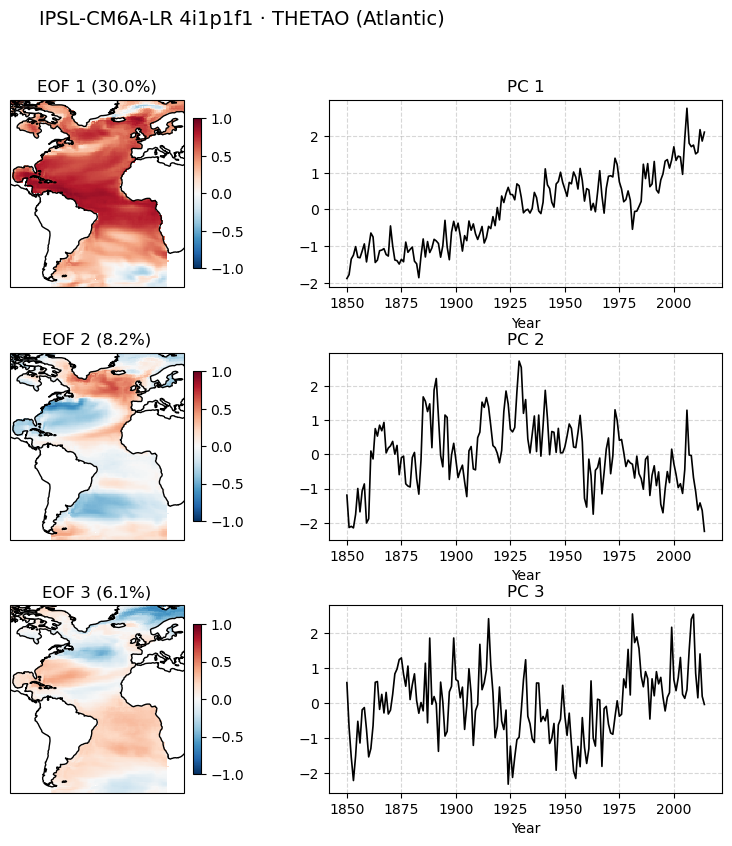

📊 Saved figure → /data/users/frekle/EOF/IPSL-CM6A-LR/Figures//thetao_EOFs_4i1p1f1_atlantic.png
=== Processing thetao: thetao_masked_r5i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_5i1p1f1.nc
=== Processing thetao: thetao_masked_r6i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_6i1p1f1.nc
=== Processing thetao: thetao_masked_r7i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_7i1p1f1.nc
=== Processing thetao: thetao_masked_r8i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_8i1p1f1.nc
=== Processing thetao: thetao_masked_r9i1p1f1.nc ===
→ 3D variable detected, selecting surface layer (olevel=0)
✅ Saved EOFs → /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/EOF_thetao_9i1p1f1.nc

🎨 Will plot figures for: []


🎯 Step 1 complete — EOFs and PCs saved for all, figures for 3 random members.


/tmp/ipykernel_1869945/514433040.py:170: FutureWarning: updating coordinate 'space', which is a PandasMultiIndex, would leave the multi-index level coordinates ['lat', 'lon'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['space', 'lat', 'lon'])` to drop the coordinates' values before assigning new coordinate values.
  eofs.assign_coords(space=anom_stacked.space)


In [9]:
# -*- coding: utf-8 -*-
"""
Compute EOFs of surface thetao for IPSL-CM6A-LR ensemble members.
(Only raw EOFs; no alignment yet.)
"""

import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof

# -----------------------------
# USER SETTINGS
# -----------------------------
MODEL = "IPSL-CM6A-LR"
VAR   = "thetao"
RUN_DIR = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao"

MEMBERS = list(range(1, 26))  # <- adjust here
NEOFS = 10                 # number of EOF modes to compute
PLOT_MODES = 3             # how many to plot

OUT_NC_DIR  = f"/data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/"
OUT_FIG_DIR = f"/data/users/frekle/EOF/IPSL-CM6A-LR/Figures/thetao"
os.makedirs(OUT_NC_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

# -----------------------------
# HELPER FUNCTIONS
# -----------------------------
def member_path(r):
    return f"{RUN_DIR}/{VAR}_masked_r{r}i1p1f1.nc"

def load_surface_thetao(path):
    ds = xr.open_dataset(path, decode_times=True)
    sst = ds[VAR].isel(olevel=0)  # surface layer
    sst = sst.rename({'lat': 'lat', 'lon': 'lon'})
    return sst

def lat_weights(lat):
    w = np.cos(np.deg2rad(lat))
    return xr.DataArray(np.sqrt(w), coords={'lat': lat}, dims='lat')

def run_eof(da, neofs=10):
    # Create 2D weights matching lat, lon
    coslat = np.cos(np.deg2rad(da['lat']))
    wgts = np.sqrt(coslat)
    wgts_2d = wgts.broadcast_like(da.isel(time=0))  # shape (lat, lon)

    solver = Eof(da, weights=wgts_2d)
    eofs = solver.eofsAsCorrelation(neofs=neofs)
    pcs = solver.pcs(npcs=neofs, pcscaling=1)
    vf = solver.varianceFraction(neigs=neofs)
    return eofs, pcs, vf


def save_nc(member, eofs, pcs, vf):
    path = f"{OUT_NC_DIR}/EOF_{VAR}_r{member}i1p1f1_raw.nc"
    xr.Dataset({
        "eofs": eofs,
        "pcs": pcs,
        "variance_fraction": vf
    }).to_netcdf(path)
    print(f"✅ Saved {path}")

# -----------------------------
# MAIN LOOP
# -----------------------------
for r in MEMBERS:
    f = member_path(r)
    if not os.path.exists(f):
        print(f"⚠️ File missing: {f}")
        continue

    print(f"\n→ Processing member r{r}i1p1f1")
    da = load_surface_thetao(f)

    # Remove temporal mean (anomalies)
    da_anom = da - da.mean('time')

    eofs, pcs, vf = run_eof(da_anom, neofs=NEOFS)
    save_nc(r, eofs, pcs, vf)

print("\n🎉 Finished EOF analysis for all members.")



→ Processing member r1i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r1i1p1f1_raw.nc

→ Processing member r2i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r2i1p1f1_raw.nc

→ Processing member r3i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r3i1p1f1_raw.nc

→ Processing member r4i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r4i1p1f1_raw.nc

→ Processing member r5i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r5i1p1f1_raw.nc

→ Processing member r6i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r6i1p1f1_raw.nc

→ Processing member r7i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r7i1p1f1_raw.nc

→ Processing member r8i1p1f1
✅ Saved /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao//EOF_thetao_r8i1p1f1_raw.nc


📊 Selected members for plotting: [21, 4, 1, 24, 9]

→ Plotting r21i1p1f1 (first 3 modes)


🖼️ Saved & displayed Atlantic EOF+PC plot for r21i1p1f1

→ Plotting r4i1p1f1 (first 3 modes)


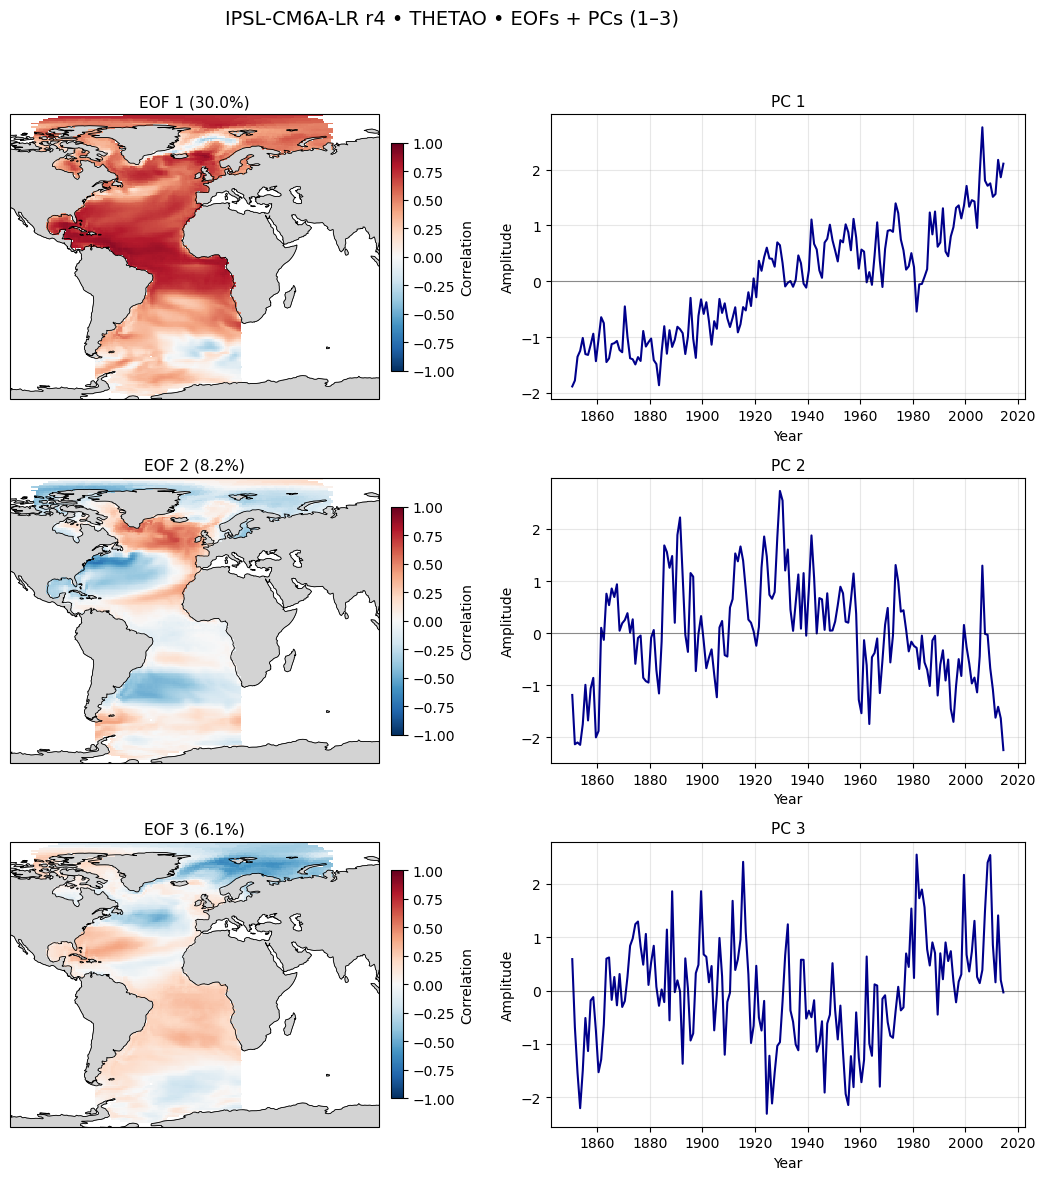

🖼️ Saved & displayed Atlantic EOF+PC plot for r4i1p1f1

→ Plotting r1i1p1f1 (first 3 modes)


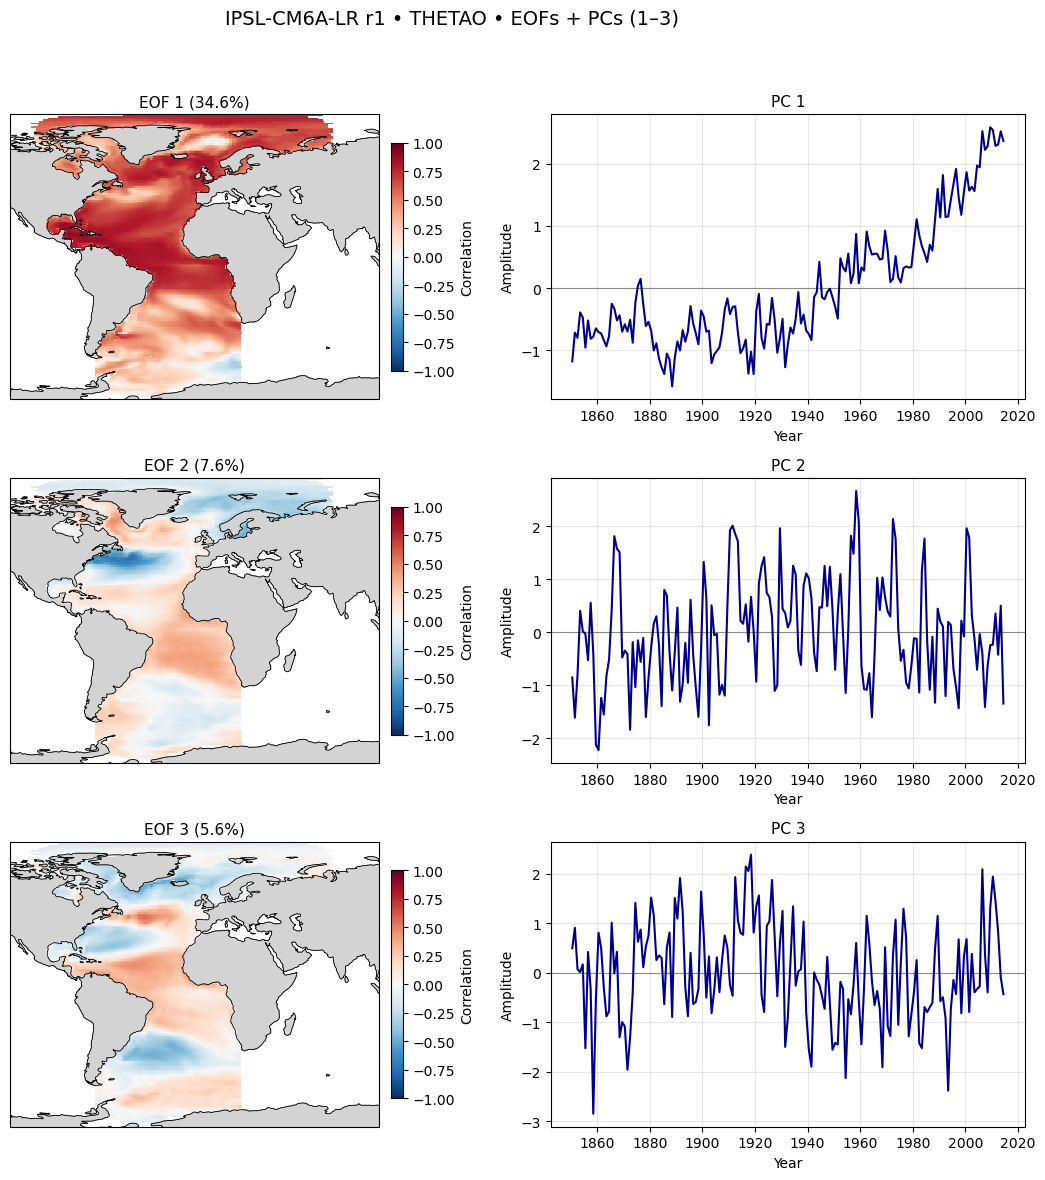

🖼️ Saved & displayed Atlantic EOF+PC plot for r1i1p1f1

→ Plotting r24i1p1f1 (first 3 modes)


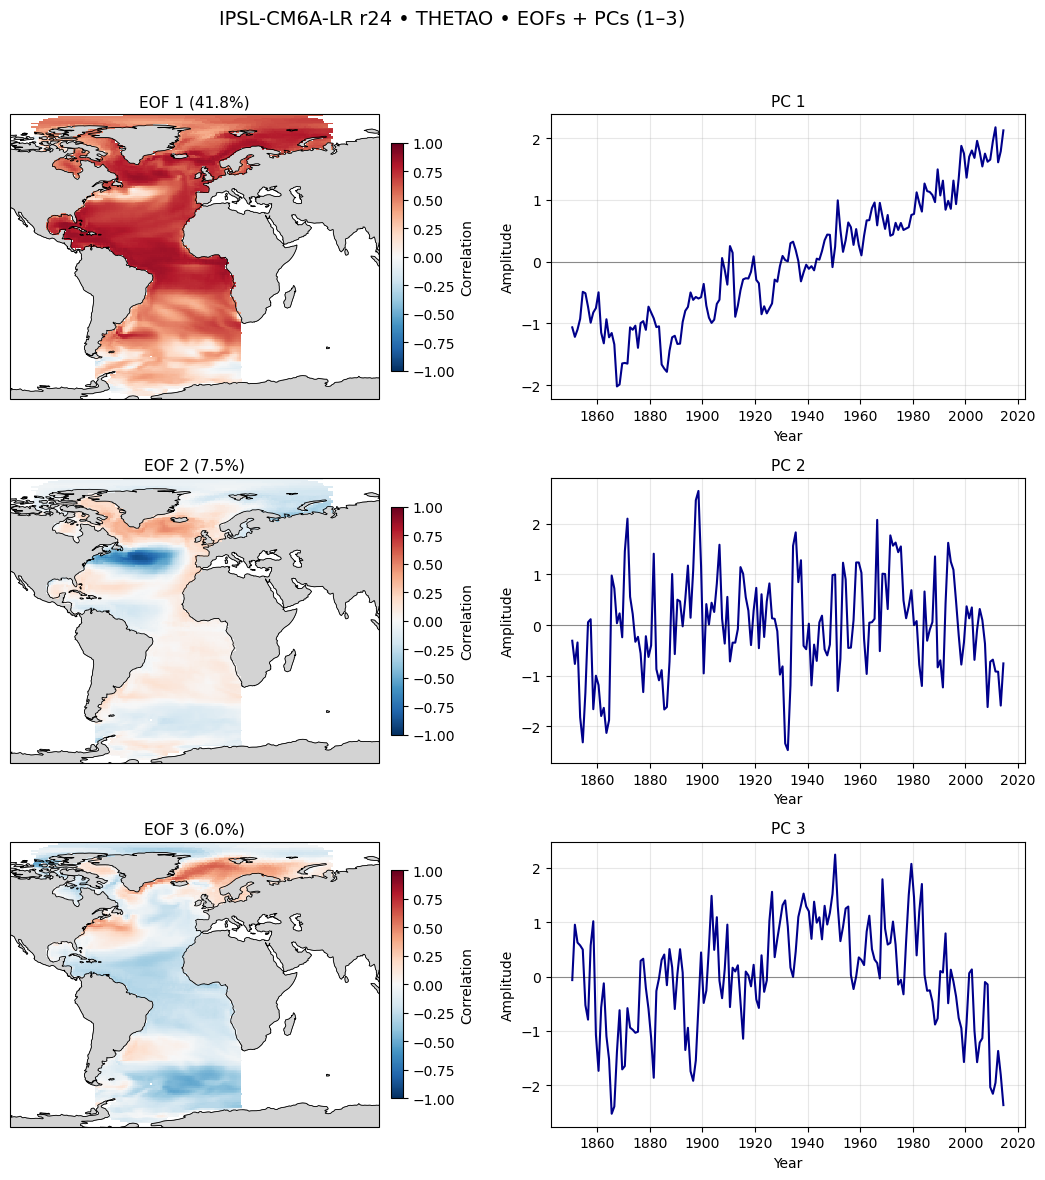

🖼️ Saved & displayed Atlantic EOF+PC plot for r24i1p1f1

→ Plotting r9i1p1f1 (first 3 modes)


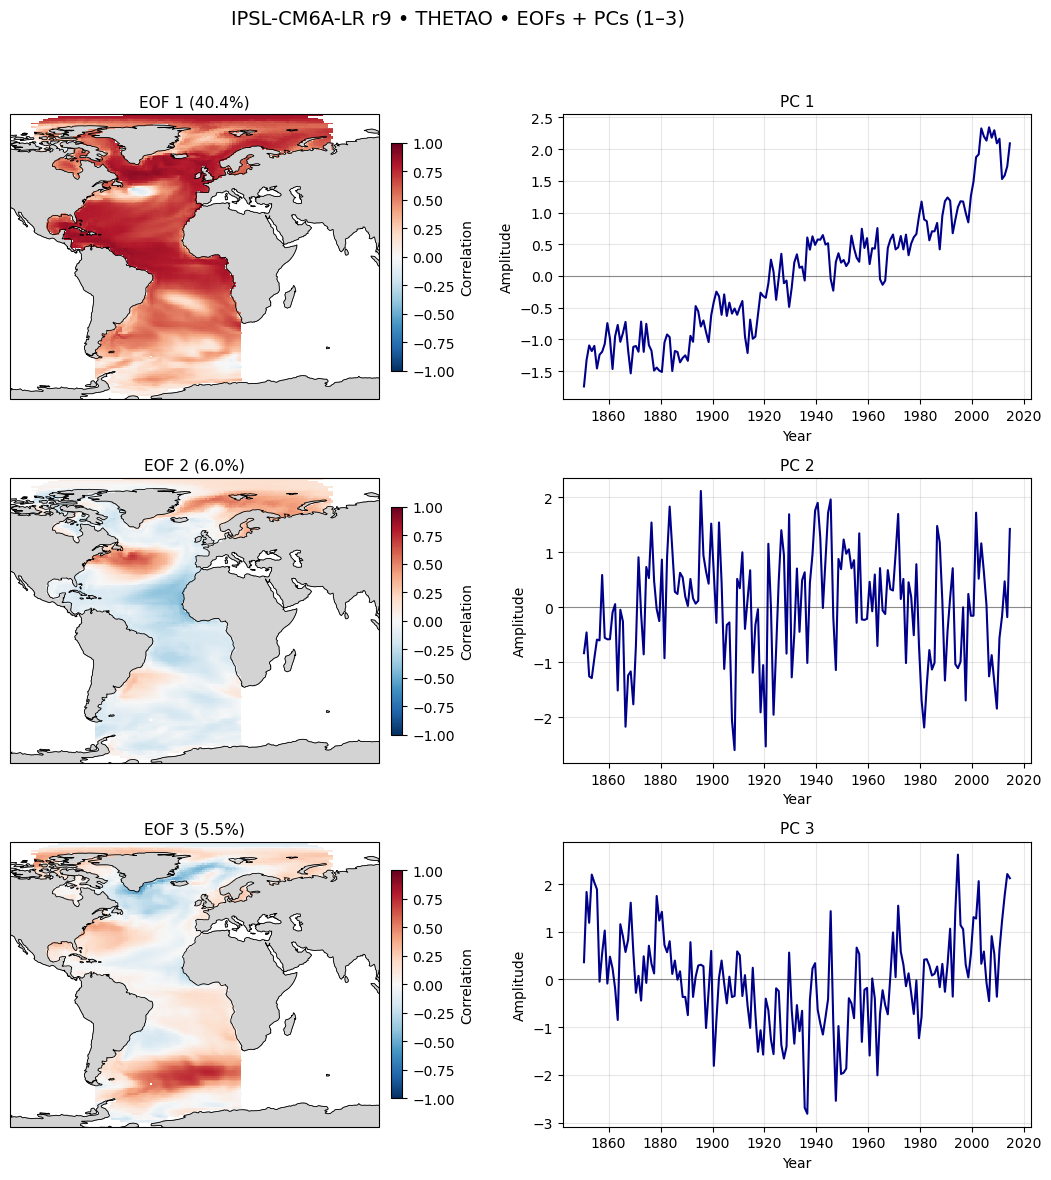

🖼️ Saved & displayed Atlantic EOF+PC plot for r9i1p1f1


In [20]:
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Choose 5 random members (set seed if you want reproducibility)
random.seed(42)
SELECTED_MEMBERS = random.sample(MEMBERS, 5)
print(f"📊 Selected members for plotting: {SELECTED_MEMBERS}")

# --- Updated plotting function ---
def plot_eofs_and_pcs(member, eofs, pcs, vf):
    PLOT_MODES = 3
    LON_MIN, LON_MAX = -120, 100
    LAT_MIN, LAT_MAX = -80, 90

    # Recenter longitudes if necessary
    lon = eofs.lon.copy()
    if lon.max() > 180:
        lon = ((lon + 180) % 360) - 180
        eofs = eofs.assign_coords(lon=lon).sortby('lon')

    # --- Create figure with 2 columns (map + PC) ---
    fig = plt.figure(figsize=(12, 4*PLOT_MODES))
    gs = fig.add_gridspec(nrows=PLOT_MODES, ncols=2, width_ratios=[1.3, 1.0])

    for i in range(PLOT_MODES):
        # --- LEFT: EOF map (Cartopy axis) ---
        ax_map = fig.add_subplot(gs[i, 0], projection=ccrs.PlateCarree())
        ax_map.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())
        ax_map.coastlines(linewidth=0.6)
        ax_map.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', linewidth=0.2)

        eof_plot = eofs.isel(mode=i)
        pcm = ax_map.pcolormesh(
            eof_plot.lon, eof_plot.lat, eof_plot,
            transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1
        )
        plt.colorbar(pcm, ax=ax_map, shrink=0.8, pad=0.02, label='Correlation')
        expl = float(vf.isel(mode=i).values) * 100
        ax_map.set_title(f"EOF {i+1} ({expl:.1f}%)", fontsize=11)

        # --- RIGHT: PC curve (normal matplotlib axis) ---
        ax_pc = fig.add_subplot(gs[i, 1])
        t = pcs['time'].values
        pc_series = pcs.isel(mode=i)
        ax_pc.plot(t, pc_series, color='darkblue', lw=1.5)
        ax_pc.axhline(0, color='k', lw=0.8, alpha=0.4)
        ax_pc.set_title(f"PC {i+1}", fontsize=11)
        ax_pc.set_xlabel("Year")
        ax_pc.set_ylabel("Amplitude")
        ax_pc.grid(True, alpha=0.3)

    plt.suptitle(f"{MODEL} r{member} • {VAR.upper()} • EOFs + PCs (1–3)", fontsize=14, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top space for title
    fpath = f"{OUT_FIG_DIR}/EOF_PC_combined_{VAR}_r{member}_atlantic.png"
    plt.savefig(fpath, dpi=300)
    plt.show()
    plt.close()
    print(f"🖼️ Saved & displayed Atlantic EOF+PC plot for r{member}i1p1f1")


# --- Call the function for 5 random members ---
for r in SELECTED_MEMBERS:
    try:
        # Load previously saved EOF results (raw)
        f = f"/data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/EOF_thetao_r{r}i1p1f1_raw.nc"
        ds = xr.open_dataset(f)
        eofs, pcs, vf = ds["eofs"], ds["pcs"], ds["variance_fraction"]

        print(f"\n→ Plotting r{r}i1p1f1 (first 3 modes)")
        plot_eofs_and_pcs(r, eofs, pcs, vf)

    except Exception as e:
        print(f"⚠️ Could not plot member r{r}i1p1f1: {e}")



### PC1 across members

In [10]:
import xarray as xr
import numpy as np
import os

# --- Paths ---
MODEL = "IPSL-CM6A-LR"
VAR = "thetao"
REF_MEMBER = 1  # reference member for alignment
PLOT_MODES = 3

IN_DIR = "/data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao"
OUT_DIR = f"{IN_DIR}/aligned"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Helper functions ---
def spatial_correlation(a, b):
    """Pearson r for two 2D EOF patterns (ignoring NaNs)."""
    a_, b_ = xr.align(a, b, join="inner")
    av, bv = a_.values, b_.values
    m = np.isfinite(av) & np.isfinite(bv)
    if m.sum() < 3:
        return np.nan
    av, bv = av[m], bv[m]
    av -= av.mean()
    bv -= bv.mean()
    return float(np.dot(av, bv) / np.sqrt(np.sum(av**2) * np.sum(bv**2)))

def map_and_sign_align(ref_eofs, mem_eofs, topmodes=3, lock_first=True):
    """
    Align EOFs of one member to reference EOFs by correlation & sign,
    optionally locking EOF1 so it is never swapped.
    """
    corr_mat = np.full((topmodes, topmodes), np.nan)
    for i in range(topmodes):
        for j in range(topmodes):
            corr_mat[i, j] = spatial_correlation(
                ref_eofs.isel(mode=i), mem_eofs.isel(mode=j)
            )

    mapping = {}
    used = set()

    # --- Step 1: Always keep EOF1 mapped to EOF1 (lock) ---
    if lock_first:
        mapping[0] = 0
        used.add(0)
    else:
        # otherwise, normal correlation-based matching
        j_best = int(np.nanargmax(corr_mat[0, :]))
        mapping[0] = j_best
        used.add(j_best)

    # --- Step 2: Match remaining modes normally ---
    for i in range(1, topmodes):
        choices = list(np.argsort(-corr_mat[i, :]))
        for j in choices:
            if j not in used and np.isfinite(corr_mat[i, j]):
                mapping[i] = int(j)
                used.add(j)
                break

    # --- Step 3: Apply mapping and fix signs ---
    aligned = []
    sign_dict = {}
    for i in range(topmodes):
        j = mapping[i]
        pat = mem_eofs.isel(mode=j)
        sign = np.sign(corr_mat[i, j])
        if np.isnan(sign) or sign == 0:
            sign = 1
        pat = pat * sign
        sign_dict[j] = sign
        aligned.append(pat)

    out = xr.concat(aligned, dim="mode").assign_coords(mode=np.arange(1, topmodes + 1))
    return out, mapping, sign_dict


def reorder_and_flip_pcs(pcs_mem, mapping, sign_dict, topmodes=PLOT_MODES):
    pcs_sel = []
    for i in range(topmodes):
        j = mapping[i]
        pc = pcs_mem.isel(mode=j)
        pc = pc * sign_dict[j]
        pcs_sel.append(pc)
    pcs_out = xr.concat(pcs_sel, dim="mode").transpose("time", "mode")
    pcs_out = pcs_out.assign_coords(mode=np.arange(1, topmodes + 1))
    return pcs_out

# --- Load reference member ---
ref_path = f"{IN_DIR}/EOF_{VAR}_r{REF_MEMBER}i1p1f1_raw.nc"
ref_ds = xr.open_dataset(ref_path)
ref_eofs = ref_ds["eofs"].isel(mode=slice(0, PLOT_MODES))
print(f"Reference: r{REF_MEMBER}i1p1f1")

# --- Loop through members to align ---
for fname in sorted(os.listdir(IN_DIR)):
    if not fname.endswith("_raw.nc"):
        continue
    member = int(fname.split("_r")[1].split("i1p1f1")[0])

    ds = xr.open_dataset(f"{IN_DIR}/{fname}")
    eofs, pcs, vf = ds["eofs"], ds["pcs"], ds["variance_fraction"]

    if member == REF_MEMBER:
        # copy reference to aligned folder
        ds.isel(mode=slice(0, PLOT_MODES)).to_netcdf(
            f"{OUT_DIR}/EOF_{VAR}_r{member}i1p1f1_aligned.nc"
        )
        print(f"✅ Reference r{member}i1p1f1 saved (unaltered).")
        continue

    print(f"\n→ Aligning r{member}i1p1f1...")
    eofs_aligned, mapping, sign_dict = map_and_sign_align(ref_eofs, eofs, PLOT_MODES)
    pcs_aligned = reorder_and_flip_pcs(pcs, mapping, sign_dict, PLOT_MODES)

    vf_top = xr.concat([vf.isel(mode=mapping[i]) for i in range(PLOT_MODES)], dim="mode")
    vf_top = vf_top.assign_coords(mode=np.arange(1, PLOT_MODES + 1))

    out_ds = xr.Dataset(
        dict(eofs=eofs_aligned, pcs=pcs_aligned, variance_fraction=vf_top)
    )
    out_path = f"{OUT_DIR}/EOF_{VAR}_r{member}i1p1f1_aligned.nc"
    out_ds.to_netcdf(out_path)
    print(f"✅ Saved aligned EOFs/PCs: {out_path}")

print("\n🎉 Alignment complete.")



Reference: r1i1p1f1

→ Aligning r10i1p1f1...
✅ Saved aligned EOFs/PCs: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/EOF_thetao_r10i1p1f1_aligned.nc

→ Aligning r11i1p1f1...
✅ Saved aligned EOFs/PCs: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/EOF_thetao_r11i1p1f1_aligned.nc

→ Aligning r12i1p1f1...
✅ Saved aligned EOFs/PCs: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/EOF_thetao_r12i1p1f1_aligned.nc

→ Aligning r13i1p1f1...
✅ Saved aligned EOFs/PCs: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/EOF_thetao_r13i1p1f1_aligned.nc

→ Aligning r14i1p1f1...
✅ Saved aligned EOFs/PCs: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/EOF_thetao_r14i1p1f1_aligned.nc

→ Aligning r15i1p1f1...
✅ Saved aligned EOFs/PCs: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/EOF_thetao_r15i1p1f1_aligned.nc

→ Aligning r16i1p1f1...
✅ Saved aligned EOFs/PCs: /data/projects/nckf/frekle/EO

### Plotting aligned vs unaligned PC1's

Looking for files with pattern: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/EOF_thetao_r*i1p1f1_raw.nc
Found 25 files
✅ Loaded 25 members from /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao
Looking for files with pattern: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/EOF_thetao_r*i1p1f1_aligned.nc
Found 25 files
✅ Loaded 25 members from /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned
📊 Found 25 common members for plotting: [1, 2, 3, 4, 5]...


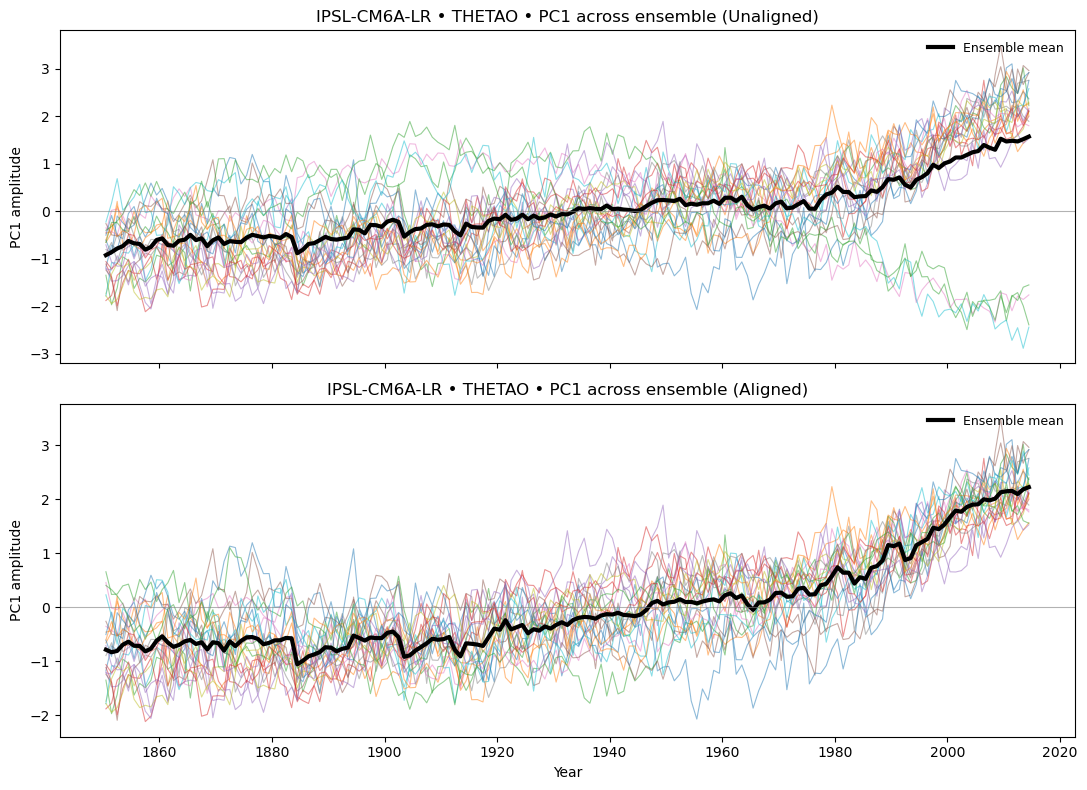


✅ Saved combined spaghetti plot: /data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao/aligned/PC1_spaghetti_comparison_fixed.png


In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import re

MODEL = "IPSL-CM6A-LR"
VAR = "thetao"
RAW_DIR = "/data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao"
ALIGNED_DIR = f"{RAW_DIR}/aligned"

# ------------------------------------------------------------
# Helper: load PC1 for all members in a directory
# ------------------------------------------------------------
def load_pc1_dict(folder, suffix):
    """
    Load PC1 from all EOF files in folder with the given suffix
    (e.g. suffix='raw' or 'aligned').
    """
    pcs_dict = {}
    pattern = os.path.join(folder, f"EOF_{VAR}_r*i1p1f1_{suffix}.nc")
    files = sorted(glob.glob(pattern))
    print(f"Looking for files with pattern: {pattern}")
    print(f"Found {len(files)} files")

    for f in files:
        fname = os.path.basename(f)  # only the filename, no path
        match = re.search(r"_r(\d+)i1p1f1", fname)
        if not match:
            print(f"⚠️ Could not extract member number from: {fname}")
            continue
        member = int(match.group(1))
        try:
            ds = xr.open_dataset(f)
            if "pcs" in ds:
                pc1 = ds["pcs"].isel(mode=0).load()
                pcs_dict[member] = pc1
        except Exception as e:
            print(f"⚠️ Problem loading {fname}: {e}")

    print(f"✅ Loaded {len(pcs_dict)} members from {folder}")
    return pcs_dict


# ------------------------------------------------------------
# Load unaligned and aligned PC1s
# ------------------------------------------------------------
pcs_raw = load_pc1_dict(RAW_DIR, "raw")
pcs_aligned = load_pc1_dict(ALIGNED_DIR, "aligned")

# --- Make sure both contain same members ---
common_members = sorted(set(pcs_raw.keys()) & set(pcs_aligned.keys()))
pcs_raw = {m: pcs_raw[m] for m in common_members}
pcs_aligned = {m: pcs_aligned[m] for m in common_members}

print(f"📊 Found {len(common_members)} common members for plotting: {common_members[:5]}...")

# ------------------------------------------------------------
# Stack into xarray for ensemble mean
# ------------------------------------------------------------
time = list(pcs_raw.values())[0]["time"]
raw_stack = xr.concat([pcs_raw[m] for m in common_members], dim="member")
aligned_stack = xr.concat([pcs_aligned[m] for m in common_members], dim="member")
raw_mean = raw_stack.mean("member")
aligned_mean = aligned_stack.mean("member")

# ------------------------------------------------------------
# Plot: spaghetti comparison (unaligned vs aligned)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

# === Unaligned ===
ax = axes[0]
for m in common_members:
    ax.plot(time, pcs_raw[m], lw=0.8, alpha=0.5)
ax.plot(time, raw_mean, color="k", lw=3, label="Ensemble mean")
ax.axhline(0, color="gray", lw=0.8, alpha=0.6)
ax.set_ylabel("PC1 amplitude")
ax.set_title(f"{MODEL} • {VAR.upper()} • PC1 across ensemble (Unaligned)", fontsize=12)
ax.legend(frameon=False, fontsize=9, loc="upper right")

# === Aligned ===
ax = axes[1]
for m in common_members:
    ax.plot(time, pcs_aligned[m], lw=0.8, alpha=0.5)
ax.plot(time, aligned_mean, color="k", lw=3, label="Ensemble mean")
ax.axhline(0, color="gray", lw=0.8, alpha=0.6)
ax.set_xlabel("Year")
ax.set_ylabel("PC1 amplitude")
ax.set_title(f"{MODEL} • {VAR.upper()} • PC1 across ensemble (Aligned)", fontsize=12)
ax.legend(frameon=False, fontsize=9, loc="upper right")

plt.tight_layout()
out_path = f"{ALIGNED_DIR}/PC1_spaghetti_comparison_fixed.png"
# plt.savefig(out_path, dpi=300)
plt.show()

print(f"\n✅ Saved combined spaghetti plot: {out_path}")






✅ loaded 25 members: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


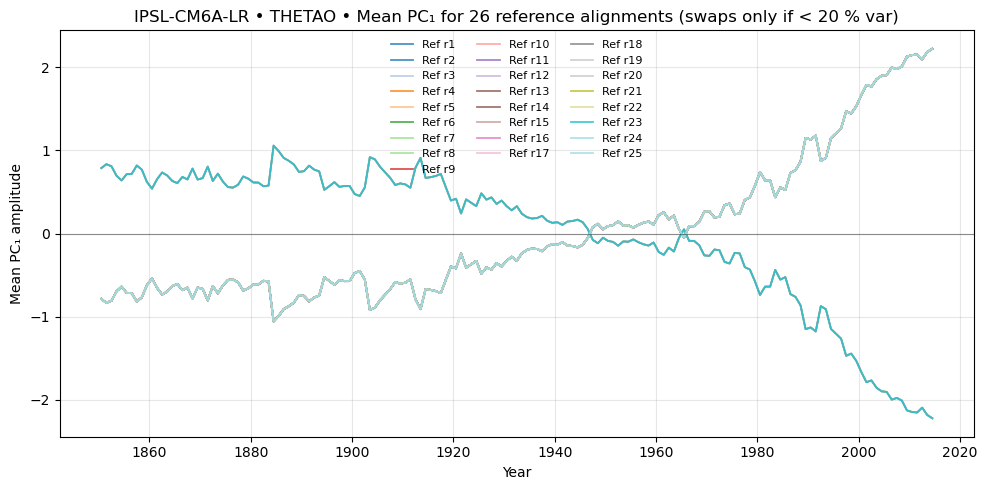

In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob, os, re

# =====================================================
# CONFIG
# =====================================================
MODEL = "IPSL-CM6A-LR"
VAR = "thetao"
IN_DIR = "/data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao"
PLOT_MODES = 3
VAR_THRESHOLD = 0.20   # only swap if variance fraction < 20 %
NREFS = 26

# =====================================================
# FUNCTIONS
# =====================================================
def spatial_correlation(a, b):
    """compute spatial correlation between two eof maps."""
    a_, b_ = xr.align(a, b, join="inner")
    av, bv = a_.values, b_.values
    mask = np.isfinite(av) & np.isfinite(bv)
    if mask.sum() < 3:
        return np.nan
    av, bv = av[mask], bv[mask]
    av -= av.mean()
    bv -= bv.mean()
    return float(np.dot(av, bv) / np.sqrt(np.sum(av**2) * np.sum(bv**2)))


def map_and_sign_align(ref_eofs, mem_eofs, ref_vf, mem_vf,
                       topmodes=PLOT_MODES, var_threshold=VAR_THRESHOLD):
    """align eofs by correlation & sign; allow swaps only if variance < threshold."""
    corr_mat = np.full((topmodes, topmodes), np.nan)
    for i in range(topmodes):
        for j in range(topmodes):
            corr_mat[i, j] = spatial_correlation(
                ref_eofs.isel(mode=i), mem_eofs.isel(mode=j)
            )

    mapping, used = {}, set()

    # loop over reference modes
    for i in range(topmodes):
        if ref_vf.isel(mode=i) > var_threshold:
            # lock this mode → same index only
            mapping[i] = i
            used.add(i)
        else:
            # allow best available match
            for j in np.argsort(-corr_mat[i, :]):
                if j not in used and np.isfinite(corr_mat[i, j]):
                    mapping[i] = int(j)
                    used.add(j)
                    break

    # apply mapping + sign
    aligned, sign_dict = [], {}
    for i in range(topmodes):
        j = mapping[i]
        pat = mem_eofs.isel(mode=j)
        sign = np.sign(corr_mat[i, j])
        if np.isnan(sign) or sign == 0:
            sign = 1
        pat = pat * sign
        sign_dict[j] = sign
        aligned.append(pat)

    out = xr.concat(aligned, dim="mode").assign_coords(mode=np.arange(1, topmodes + 1))
    return out, mapping, sign_dict


def reorder_and_flip_pcs(pcs_mem, mapping, sign_dict, topmodes=PLOT_MODES):
    """reorder & flip pcs according to eof mapping and sign."""
    pcs_sel = []
    for i in range(topmodes):
        j = mapping[i]
        pc = pcs_mem.isel(mode=j) * sign_dict[j]
        pcs_sel.append(pc)
    pcs_out = xr.concat(pcs_sel, dim="mode").transpose("time", "mode")
    pcs_out = pcs_out.assign_coords(mode=np.arange(1, topmodes + 1))
    return pcs_out


# =====================================================
# LOAD RAW EOF/PC DATA
# =====================================================
raw_files = sorted(glob.glob(os.path.join(IN_DIR, f"EOF_{VAR}_r*i1p1f1_raw.nc")))

members = []
eofs_all, pcs_all, vf_all = {}, {}, {}

for f in raw_files:
    fname = os.path.basename(f)
    m = re.search(r"_r(\d+)i1p1f1", fname)
    if not m:
        continue
    member = int(m.group(1))
    ds = xr.open_dataset(f)
    eofs_all[member] = ds["eofs"].isel(mode=slice(0, PLOT_MODES))
    pcs_all[member] = ds["pcs"].isel(mode=slice(0, PLOT_MODES))
    # ✅ corrected variable name
    vf_all[member] = ds["variance_fraction"].isel(mode=slice(0, PLOT_MODES))
    members.append(member)

members = sorted(members)
print(f"✅ loaded {len(members)} members: {members}")

# =====================================================
# ALIGN TO EACH MEMBER AS REFERENCE AND COMPUTE MEAN PC1
# =====================================================
mean_pc1_allrefs = []

for ref in members:
    ref_eofs = eofs_all[ref]
    ref_vf = vf_all[ref]
    aligned_pcs = []

    for mem in members:
        eofs_mem = eofs_all[mem]
        pcs_mem = pcs_all[mem]
        mem_vf = vf_all[mem]

        if mem == ref:
            pcs_aligned = pcs_mem.isel(mode=0)
        else:
            eofs_aligned, mapping, sign_dict = map_and_sign_align(
                ref_eofs, eofs_mem, ref_vf, mem_vf,
                topmodes=PLOT_MODES, var_threshold=VAR_THRESHOLD
            )
            pcs_aligned = reorder_and_flip_pcs(pcs_mem, mapping, sign_dict).isel(mode=0)
        aligned_pcs.append(pcs_aligned)

    stack = xr.concat(aligned_pcs, dim="member")
    mean_pc1 = stack.mean("member")
    mean_pc1_allrefs.append(mean_pc1)

pc_means = xr.concat(mean_pc1_allrefs, dim="ref")
pc_means = pc_means.assign_coords(ref=("ref", members))
time = pc_means["time"]

# =====================================================
# PLOT ALL MEAN PC1 CURVES
# =====================================================
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.tab20(np.linspace(0, 1, len(members)))

for c, ref in zip(colors, members):
    ax.plot(time, pc_means.sel(ref=ref), lw=1.3, alpha=0.8, color=c, label=f"Ref r{ref}")

ax.axhline(0, color="k", lw=0.8, alpha=0.4)
ax.set_title(f"{MODEL} • {VAR.upper()} • Mean PC₁ for 26 reference alignments (swaps only if < 20 % var)", fontsize=12)
ax.set_xlabel("Year")
ax.set_ylabel("Mean PC₁ amplitude")
ax.legend(ncol=3, fontsize=8, frameon=False)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()






✅ Loaded 25 members.
🎯 References: [21, 4, 1, 24, 9]
Ref r21: mean PC1 variance=0.278
Ref r4: mean PC1 variance=0.278
Ref r1: mean PC1 variance=0.278
Ref r24: mean PC1 variance=0.278
Ref r9: mean PC1 variance=0.278


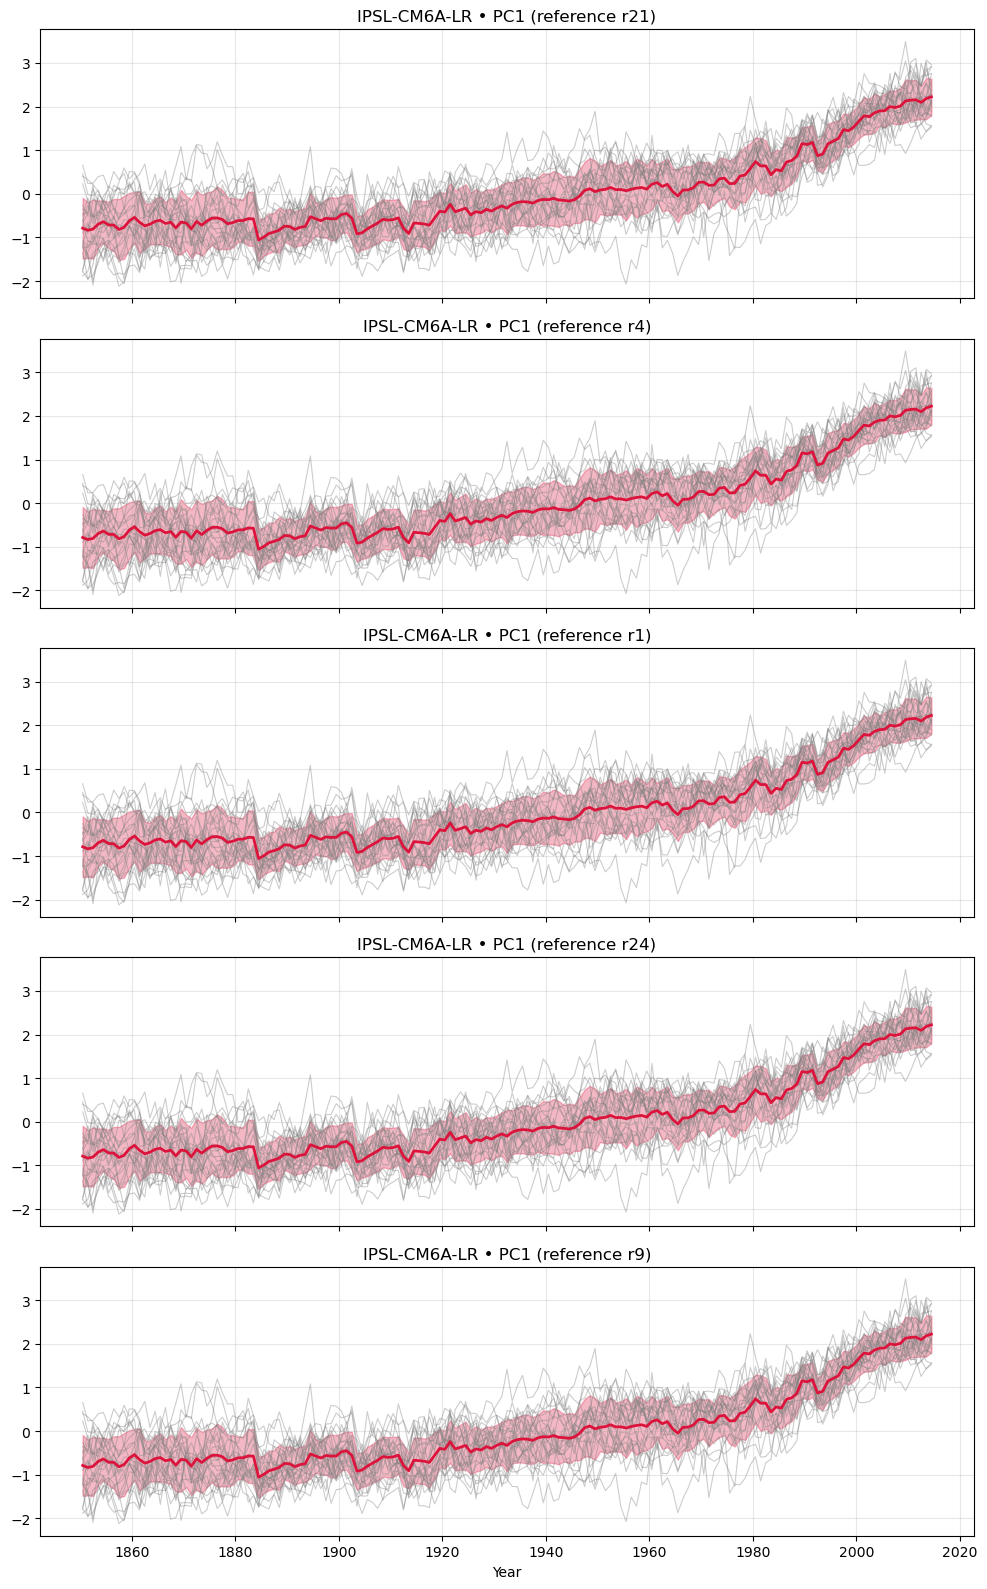

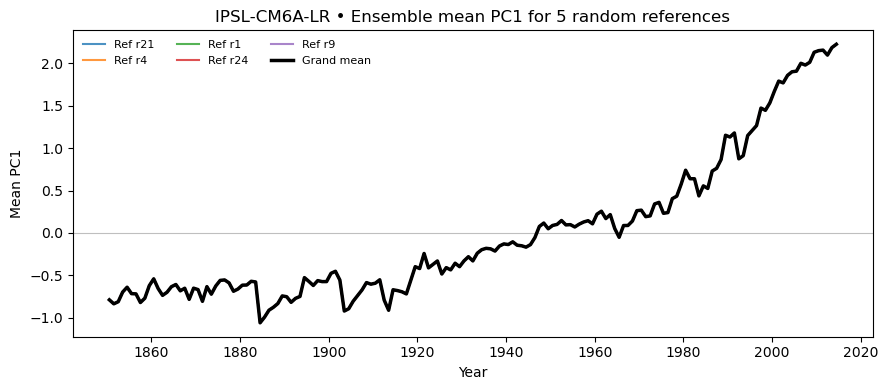

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random, glob, os, re

MODEL = "IPSL-CM6A-LR"
VAR = "thetao"
IN_DIR = "/data/projects/nckf/frekle/EOF_results/IPSL-CM6A-LR/thetao"
PLOT_MODES = 1
N_RANDOM = 5

# ---------- Helper functions ----------
def spatial_correlation(a, b):
    a_, b_ = xr.align(a, b, join="inner")
    av, bv = a_.values, b_.values
    mask = np.isfinite(av) & np.isfinite(bv)
    if mask.sum() < 3: return np.nan
    av, bv = av[mask], bv[mask]
    av -= av.mean(); bv -= bv.mean()
    return float(np.dot(av, bv) / np.sqrt(np.sum(av**2) * np.sum(bv**2)))

def map_and_sign_align(ref_eofs, mem_eofs):
    corr_mat = np.full((PLOT_MODES, PLOT_MODES), np.nan)
    for i in range(PLOT_MODES):
        for j in range(PLOT_MODES):
            corr_mat[i,j] = spatial_correlation(ref_eofs.isel(mode=i), mem_eofs.isel(mode=j))
    mapping = {i:int(np.nanargmax(corr_mat[i,:])) for i in range(PLOT_MODES)}
    aligned, sign_dict = [], {}
    for i in range(PLOT_MODES):
        j = mapping[i]
        pat = mem_eofs.isel(mode=j)
        sgn = np.sign(corr_mat[i,j])
        pat = pat * (1 if np.isnan(sgn) or sgn==0 else sgn)
        sign_dict[j] = sgn
        aligned.append(pat)
    out = xr.concat(aligned, dim="mode").assign_coords(mode=np.arange(1, PLOT_MODES+1))
    return out, mapping, sign_dict

def reorder_and_flip_pcs(pcs_mem, mapping, sign_dict):
    pcs_sel=[]
    for i in range(PLOT_MODES):
        j=mapping[i]
        pc=pcs_mem.isel(mode=j)*sign_dict[j]
        pcs_sel.append(pc)
    pcs_out=xr.concat(pcs_sel,dim="mode").transpose("time","mode")
    pcs_out=pcs_out.assign_coords(mode=np.arange(1,PLOT_MODES+1))
    return pcs_out

# ---------- Load data ----------
raw_files = sorted(glob.glob(os.path.join(IN_DIR, f"EOF_{VAR}_r*i1p1f1_raw.nc")))
eofs_all, pcs_all, members = {}, {}, []
for f in raw_files:
    m = re.search(r"_r(\d+)i1p1f1", os.path.basename(f))
    if not m: continue
    member=int(m.group(1))
    ds=xr.open_dataset(f)
    eofs_all[member]=ds["eofs"].isel(mode=slice(0,PLOT_MODES))
    pcs_all[member]=ds["pcs"].isel(mode=slice(0,PLOT_MODES))
    members.append(member)
members=sorted(members)
print(f"✅ Loaded {len(members)} members.")

# ---------- Pick random references ----------
random.seed(42)
refs=random.sample(members,N_RANDOM)
print(f"🎯 References: {refs}")

# ---------- Compute & store ensemble means ----------
mean_curves=[]
for ref in refs:
    ref_eofs=eofs_all[ref]
    pcs_aligned=[]
    for mem in members:
        eofs_mem=eofs_all[mem]; pcs_mem=pcs_all[mem]
        if mem==ref:
            pcs_aligned.append(pcs_mem.isel(mode=0))
        else:
            eofsA,mapping,sign_dict=map_and_sign_align(ref_eofs,eofs_mem)
            pcsA=reorder_and_flip_pcs(pcs_mem,mapping,sign_dict).isel(mode=0)
            pcs_aligned.append(pcsA)
    stack=xr.concat(pcs_aligned,dim="member")
    mean_curves.append(stack.mean("member"))
    print(f"Ref r{ref}: mean PC1 variance={float(stack.var('member').mean()):.3f}")

time=mean_curves[0]["time"]

# ---------- Plot: one panel per reference ----------
fig,axes=plt.subplots(N_RANDOM,1,figsize=(10,3.2*N_RANDOM),sharex=True)
for ax,ref,mean_pc in zip(axes,refs,mean_curves):
    # plot all member PCs (thin grey)
    ref_eofs=eofs_all[ref]
    pcs_aligned=[]
    for mem in members:
        eofs_mem=eofs_all[mem]; pcs_mem=pcs_all[mem]
        if mem==ref:
            pcs_aligned.append(pcs_mem.isel(mode=0))
        else:
            eofsA,mapping,sign_dict=map_and_sign_align(ref_eofs,eofs_mem)
            pcsA=reorder_and_flip_pcs(pcs_mem,mapping,sign_dict).isel(mode=0)
            pcs_aligned.append(pcsA)
    stack=xr.concat(pcs_aligned,dim="member")
    for i in range(stack.sizes["member"]):
        ax.plot(stack["time"],stack.isel(member=i),color="gray",alpha=0.4,lw=0.8)
    # red mean ± std
    m=stack.mean("member"); s=stack.std("member")
    ax.plot(time,m,color="crimson",lw=2)
    ax.fill_between(time.values,(m-s).values,(m+s).values,color="crimson",alpha=0.3)
    ax.set_title(f"{MODEL} • PC1 (reference r{ref})")
    ax.grid(alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

# ---------- Overlay all five mean curves ----------
plt.figure(figsize=(9,4))
for ref,mc in zip(refs,mean_curves):
    plt.plot(time,mc,lw=1.5,alpha=0.8,label=f"Ref r{ref}")
plt.axhline(0,color="gray",lw=0.8,alpha=0.5)
plt.plot(time,sum(mean_curves)/len(mean_curves),color="black",lw=2.5,label="Grand mean")
plt.title(f"{MODEL} • Ensemble mean PC1 for 5 random references")
plt.xlabel("Year"); plt.ylabel("Mean PC1")
plt.legend(ncol=3,fontsize=8,frameon=False)
plt.tight_layout()
plt.show()


